In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import copy
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import os
from torch.cuda.amp import GradScaler
scaler = GradScaler()

In [2]:


data_dir = 'Anime'

dataset = ImageFolder(data_dir,
                     transform = T.Compose([
                         T.Resize(255),
                         T.CenterCrop(224),
                         T.RandomHorizontalFlip(),
                         T.RandomRotation(10),
                         T.RandomGrayscale(),
                         T.RandomAffine(translate=(0.05,0.05), degrees = 0),
                         T.ToTensor()
#                          T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225], inplace = True)
                     ]))


In [3]:

print(len(dataset.classes))
print(dataset)

248
Dataset ImageFolder
    Number of datapoints: 54700
    Root location: Anime
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomGrayscale(p=0.1)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05))
               ToTensor()
           )


In [4]:
random_seed = 2020
torch.manual_seed(random_seed)

train_size = round(len(dataset)*0.8) # 70%
val_size = len(dataset) - train_size # 30%

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(43760, 10940)

In [5]:


batch_size = 16
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4)

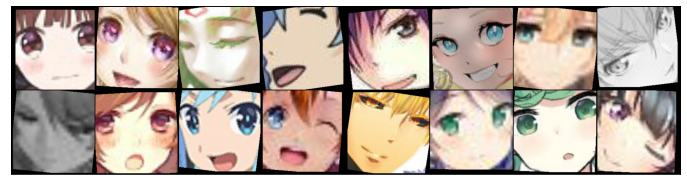

In [6]:


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow = 8).permute(1,2,0))
        break
        
show_batch(train_dl)

In [7]:


def get_default_device():
    if torch.cuda.is_available():
#         return torch.device('cpu')
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')
    
device = get_default_device()

In [8]:


def to_device(data, device):
    
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [9]:


class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [10]:


def accuracy(outputs, labels):

    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/ len(preds)), preds

def F1_score(outputs, lables):
    _, pres = torch.max(outputs, dim = 1)
    
    cm = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return precision, recall, f1, preds

In [11]:
class ModelBase(nn.Module):
    def training_step(self, batch):
        
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        
        acc, preds = accuracy(out, labels)
        
        return {'train_loss':loss, 'train_acc':acc}
    
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        
        epoch_loss = torch.stack(batch_losses).mean()
        
        batch_accs = [x['train_acc'] for x in outputs]
        
        epoch_acc = torch.stack(batch_accs).mean()
        
        return {'train_loss':epoch_loss.item(), 'train_acc':epoch_acc.item() }
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        
        loss = F.cross_entropy(out, labels)
        
        acc, preds = accuracy(out, labels)
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 'preds':preds.detach(), 'labels': labels.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        
        epoch_loss = torch.stack(batch_losses).mean()
        
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        
        return {'val_loss': epoch_loss.item(),'val_acc':epoch_acc.item()}
    
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'
              .format(epoch+1, train_result['train_loss'], train_result['train_acc'], val_result['val_loss'], val_result['val_acc']))
        
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        
        epoch_loss = torch.stack(batch_losses).mean()
        
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()]
        
        batch_preds = [pred for x in outputs for pred in x['labels'].tolist()]
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}  

In [12]:
class ResNet(ModelBase):
    def __init__(self, num_labels):
        super().__init__()
        
        self.network = models.resnet200(pretrained = True)
        self.network.fc = nn.Linear(self.network.fc.in_features, num_labels)
        
    def forward(self, x):
        return self.network(x)
    
class GoogleNet(ModelBase):
    def __init__(self, num_labels):
        super().__init__()
        
        self.network = models.googlenet(pretrained = True)
        self.network.fc = nn.Linear(self.network.fc.in_features, num_labels)
        
    def forward(self, x):
        return self.network(x)
    
class EffNetV2(ModelBase):
    def __init__(self,pretrained = True, labels=1) -> None:
        super().__init__()
        self.backbone = timm.create_model('tf_efficientnetv2_b3', pretrained = pretrained)
        self.backbone.classifier = nn.Linear(self.backbone.classifier.in_features,labels)
#         self.backbone.classifier = nn.Sequential(
#                 nn.Linear(self.backbone.classifier.in_features,4096),
#                 nn.ReLU(),
#                 nn.Dropout(p=0.5),
#                 nn.Linear(4096,labels)
#         )
        
    def forward(self,x)->torch.Tensor:
        out = self.backbone(x)
        return out
    
class VitModel(ModelBase):
    def __init__(self, pretrained = True, labels = 1)->None:
        super().__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained = pretrained)
        self.model.head = nn.Linear(self.model.head.in_features, labels)
        
    def forward(self, x)->torch.Tensor:
        out = self.model(x)
        return out

In [13]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, lr, model, train_loader, val_loader, weight, weight_decay = 0, grad_clip = None, opt_func = torch.optim.SGD):
    torch.cuda.empty_cache()
    history = {}
    
    optimizer = opt_func(model.parameters(), lr)
    
    best_loss = 1
    
    for epoch in range(epochs):
        lrs = []
        print(get_lr(optimizer))
        if epoch == 5:
            
            lr = 1e-6
        elif epoch ==15:
            lr = 1e-7
            
            optimizer = opt_func(model.parameters(), lr)
        if epoch != 0:
            model.train()
            train_outputs = []
            
            for batch in tqdm(train_loader):
                outputs = model.training_step(batch)
                loss = outputs['train_loss']

                train_outputs.append(outputs)

                train_results = model.train_epoch_end(train_outputs)
    #             loss.backward()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                if grad_clip:
                    nn.utils.clip_grad_value_(model.parameters(), grad_clip)

                optimizer.step()
                optimizer.zero_grad()
        else:
            train_results = {'train_loss':0, 'train_acc':0}
            
            
            
        val_results = evaluate(model, val_loader)

        if val_results['val_loss']<best_loss:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())

        model.epoch_end(epoch, train_results, val_results)
        to_add = {'train_loss': train_results['train_loss'],
              'train_acc': train_results['train_acc'],
             'val_loss': val_results['val_loss'],
              'val_acc': val_results['val_acc'], 'lrs':lrs}

        # update performance dictionary
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
                    
    model.load_state_dict(best_model_wts)                         # load best model
    
    return history, optimizer, best_loss

In [14]:
ResNettrain_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model = to_device(ResNet(num_labels = len(dataset.classes)),device)


In [15]:
epochs = 20
lr = 1e-4
grad_clip = None
weight_decay = 1e-5
opt_func = torch.optim.Adam
# weighted loss for data class imbalance
weight = torch.FloatTensor([3876/(1342+3876), 1342/(1342+3876)]).to(device)

In [16]:
history, optimizer, best_loss = fit(epochs, lr, model, train_dl, val_dl, weight, 
                                    grad_clip=grad_clip, 
                                    weight_decay=weight_decay, 
                                    opt_func=opt_func)

0.0001



Epoch [1], train_loss: 0.0000, train_acc: 0.0000, val_loss: 5.5396, val_acc: 0.0044
0.0001



Epoch [2], train_loss: 2.0652, train_acc: 0.5414, val_loss: 1.0820, val_acc: 0.7238
0.0001



Epoch [3], train_loss: 0.9745, train_acc: 0.7486, val_loss: 0.8333, val_acc: 0.7813
0.0001



Epoch [4], train_loss: 0.6924, train_acc: 0.8162, val_loss: 0.7317, val_acc: 0.8109
0.0001



Epoch [5], train_loss: 0.5299, train_acc: 0.8554, val_loss: 0.7414, val_acc: 0.8159
0.0001



Epoch [6], train_loss: 0.4142, train_acc: 0.8815, val_loss: 0.7204, val_acc: 0.8244
0.0001



Epoch [7], train_loss: 0.3301, train_acc: 0.9042, val_loss: 0.7551, val_acc: 0.8230
0.0001



Epoch [8], train_loss: 0.2756, train_acc: 0.9203, val_loss: 0.7534, val_acc: 0.8266
0.0001



Epoch [9], train_loss: 0.2347, train_acc: 0.9300, val_loss: 0.7816, val_acc: 0.8256
0.0001



Epoch [10], train_loss: 0.2028, train_acc: 0.9381, val_loss: 0.8200, val_acc: 0.8200
0.0001



Epoch [11], train_loss: 0.1852, train_acc: 0.9444, val_loss: 0.8350, val_acc: 0.8274
0.0001



Epoch [12], train_loss: 0.1676, train_acc: 0.9502, val_loss: 0.8403, val_acc: 0.8279
0.0001



Epoch [13], train_loss: 0.1564, train_acc: 0.9523, val_loss: 0.8763, val_acc: 0.8268
0.0001



Epoch [14], train_loss: 0.1397, train_acc: 0.9577, val_loss: 0.8689, val_acc: 0.8314
0.0001



Epoch [15], train_loss: 0.1361, train_acc: 0.9584, val_loss: 0.8700, val_acc: 0.8335
0.0001



Epoch [16], train_loss: 0.0941, train_acc: 0.9716, val_loss: 0.8510, val_acc: 0.8368
1e-07



Epoch [17], train_loss: 0.0958, train_acc: 0.9711, val_loss: 0.8576, val_acc: 0.8362
1e-07



Epoch [18], train_loss: 0.0933, train_acc: 0.9713, val_loss: 0.8385, val_acc: 0.8403
1e-07



Epoch [19], train_loss: 0.0917, train_acc: 0.9731, val_loss: 0.8406, val_acc: 0.8394
1e-07



Epoch [20], train_loss: 0.0875, train_acc: 0.9738, val_loss: 0.8514, val_acc: 0.8369


In [17]:
torch.save(model.state_dict(), f'Resnet_anime.pt')